<a href="https://colab.research.google.com/github/sbogde/pandamonium/blob/main/dmi_04_pollution_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Pollution Data Clustering

**Data Source:** This dataset comes from [Kaggle's Global Air Pollution Dataset](https://www.kaggle.com/datasets/hasibalmuzdadid/global-air-pollution-dataset).

We will use K-Means clustering on a global air pollution dataset to identify highly polluted areas.
The dataset contains information on various pollutants such as CO, Ozone, NO2, and PM2.5 for different cities around the world.

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import folium
from folium.plugins import MarkerCluster

from geopy.geocoders import Nominatim

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/My Drive/Colab Notebooks/data-mining/data/global_air_pollution.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './data/global_air_pollution.csv'  # Local path

Mounted at /content/drive


In [3]:
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)

Dataset shape: (23463, 12)


In [4]:
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


In [5]:
pollutant_cols = ['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']

df[pollutant_cols] = df[pollutant_cols].fillna(0)

df[pollutant_cols].describe()

,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
count,23463.000000,23463.000000,23463.000000,23463.000000
mean,1.368367,35.193709,3.063334,68.519755
std,1.832064,28.098723,5.254108,54.796443
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,35.000000
50%,1.000000,31.000000,1.000000,54.000000
75%,1.000000,40.000000,4.000000,79.000000
max,133.000000,235.000000,91.000000,500.000000


In [6]:
# Standardise the pollutant columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[pollutant_cols] = scaler.fit_transform(df_scaled[pollutant_cols])
print("Scaled pollutant values (first 5 rows):")
df_scaled[pollutant_cols].head()

Scaled pollutant values (first 5 rows):


,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,-0.201071,0.028696,-0.583048,-0.319731
1,-0.201071,-1.074581,-0.392717,-0.502229
2,-0.201071,0.135464,-0.202386,-0.045985
3,-0.201071,-0.042484,-0.583048,-0.885473
4,-0.746915,-0.469558,-0.583048,-1.140970


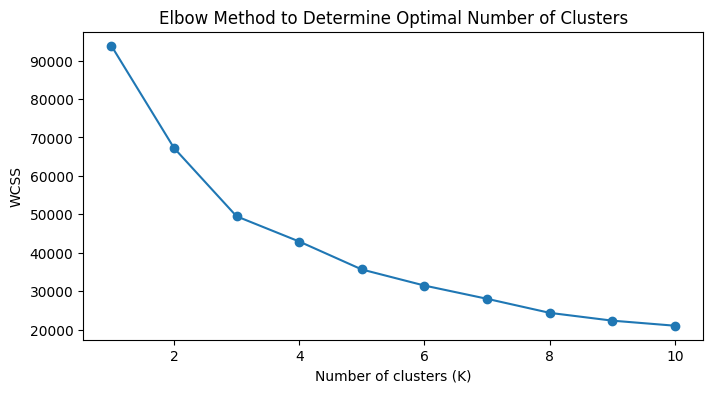

In [7]:
wcss = []
for k in range(1, 11):
    kmeans_temp = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_temp.fit(df_scaled[pollutant_cols])
    wcss.append(kmeans_temp.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method to Determine Optimal Number of Clusters")
plt.xlabel("Number of clusters (K)")
plt.ylabel("WCSS")
plt.show()

In [8]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled[pollutant_cols])
print("Cluster distribution:")
df_scaled['Cluster'].value_counts()

Cluster distribution:


,count
Cluster,
0,16879
3,4537
1,1384
2,663


In [9]:
cluster_summary = df_scaled.groupby('Cluster')[pollutant_cols].mean()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value
Cluster                                                               
0           -0.264261        -0.136074      -0.332930        -0.417575
1            0.792018         3.176058      -0.133624         2.077856
2            3.004837        -0.721638       3.963946         1.583032
3            0.302424        -0.357157       0.700104         0.688329


In [ ]:
geolocator = Nominatim(user_agent="air_pollution_clustering")

def get_lat_lon(city, country):
    try:
        location = geolocator.geocode(f"{city}, {country}", timeout=10)
        if location:
            return location.latitude, location.longitude
        else:
            return np.nan, np.nan
    except Exception as e:
        return np.nan, np.nan

if 'Latitude' not in df.columns or 'Longitude' not in df.columns:
    latitudes = []
    longitudes = []
    for idx, row in df.iterrows():
        lat, lon = get_lat_lon(row['City'], row['Country'])
        latitudes.append(lat)
        longitudes.append(lon)
        time.sleep(1)
    df['Latitude'] = latitudes
    df['Longitude'] = longitudes

df = df.dropna(subset=['Latitude', 'Longitude'])
print("After geocoding, dataset shape:", df.shape)

In [ ]:
# Create an interactive world map centred on [20, 0]
world_map = folium.Map(location=[20, 0], zoom_start=2)
marker_cluster = MarkerCluster().add_to(world_map)

# Define colours for clusters (adjust if optimal_k > len(colors))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred']

# Add markers for each city based on its cluster assignment
for idx, row in df_scaled.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['City']}, {row['Country']}<br>Cluster: {row['Cluster']}<br>CO: {row['CO AQI Value']:.2f}",
        icon=folium.Icon(color=colors[row['Cluster'] % len(colors)])
    ).add_to(marker_cluster)

# Save the map as an HTML file
world_map.save("air_pollution_clusters_map.html")
print("Map has been saved as 'air_pollution_clusters_map.html'.")
